In [1]:
from math import pi
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import IPython

In [2]:
def LinkwitzRiley12dB(fc, sr):
    omega = 2 * pi * fc / sr
    
    sineOmega = np.sin(omega)
    cosineOmega = np.cos(omega)
    a0 = 1 + sineOmega + cosineOmega
    
    A1 = (sineOmega - cosineOmega - 1) / a0
    B0 = (sineOmega) / a0
    B1 = (sineOmega) / a0
    
    b_lp = np.convolve([B0, B1], [B0, B1])
    a_lp = np.convolve([1, A1], [1, A1])
    
    A1 = (sineOmega - cosineOmega - 1) / a0
    B0 = (1 + cosineOmega) / a0
    B1 = -(1 + cosineOmega) / a0
    
    b_hp = np.convolve([B0, B1], [B0, B1])
    a_hp = np.convolve([1, A1], [1, A1])
    
    # two transfer function need to substract to achieve all-pass filter  
    return [-b_lp, a_lp], [b_hp, a_hp]

In [3]:
def LinkwitzRiley24dB(fc, sr):
    omega = 2 * pi * fc / sr
    
    sineOmega = np.sin(omega)
    cosinePmega = np.cos(omega)
    alpha = sineOmega * np.sqrt(2) / 2
    a0 = 1 + alpha
    
    A1 = -( 2 * cosinePmega) / a0
    A2 = (1 - alpha) / a0
    B1 = (1 - cosinePmega) / a0 
    B0 = B1 / 2
    B2 = B0
    
    b_lp = np.convolve([B0, B1, B2], [B0, B1, B2])
    a_lp = np.convolve([1, A1, A2], [1, A1, A2])
    
    A1 = -(2 * cosinePmega) / a0
    A2 = (1 - alpha) / a0
    B1 = -(1 + cosinePmega) / a0
    B0 = -B1 / 2
    B2 = B0
    
    b_hp = np.convolve([B0, B1, B2], [B0, B1, B2])
    a_hp = np.convolve([1, A1, A2], [1, A1, A2])
    
    return [b_lp, a_lp], [b_hp, a_hp]

In [4]:
def LinkwitzRiley48dB(fc, sr):
    omega = 2 * pi * fc / sr
    
    sineOmega = np.sin(omega)
    cosinePmega = np.cos(omega)
    
    orderindex = [0, 1, 0, 1]
    b_lp = [1]
    a_lp = [1]
    b_hp = [1]
    a_hp = [1]
    for index in orderindex:
        orderangle = (np.pi / 4) * (index + 0.5)
        alpha = sineOmega / (2 * (1 / (2 * np.sin(orderangle))))
    
        a0 = 1 + alpha

        A1 = -( 2 * cosinePmega) / a0
        A2 = (1 - alpha) / a0
        B1 = (1 - cosinePmega) / a0 
        B0 = B1 / 2
        B2 = B0
        A0 = 1

        b_lp = np.convolve(b_lp, [B0, B1, B2])
        a_lp = np.convolve(a_lp, [A0, A1, A2])
    
        A1 = -(2 * cosinePmega) / a0
        A2 = (1 - alpha) / a0
        B1 = -(1 + cosinePmega) / a0
        B0 = -B1 / 2
        B2 = B0

        b_hp = np.convolve(b_hp, [B0, B1, B2])
        a_hp = np.convolve(a_hp, [A0, A1, A2])

    return [b_lp, a_lp], [b_hp, a_hp]

In [5]:
def _coefficient_convolve(h1, h2):
    return np.convolve(h1[0], h2[0]), np.convolve(h1[1], h2[1])

def cascade(data):
    temp = [[1],[1]]
    for element in data:
        temp = _coefficient_convolve(element, temp)
    return temp

def fc2tick(fc, fs, length):
    return fc * 2 / fs * length

def tick2fc(tick, fs, length):
    return tick / length * fs / 2

$F_n$ denotes low-pass filter and $\tilde{F_n}$ with tilde symbol on top denotes power complementary high-pass filter respectively.An all-pass filter could be derived as sum up of $F_n$ and $\tilde{F_n}$.

$$
H(z) = F_n(z) + \tilde{F_n(z)}
$$

Beware the sum up of $F_2(z) \cdot A_{1,1}(z) + \tilde{F_2}(z) \cdot A_{3,1}(z)$ could not resolve as all-pass filter as below.

$$
\begin{align}
H(z) 
&= H_0(z) + H_1(z) + H_2(z) + H_3(z) \\
&= F_2(z) \cdot (F_1(z) + \tilde{F_1}(z)) + \tilde{F_2}(z) \cdot (F_3(z) + \tilde{F_3}(z)) \\
&= F_2(z) \cdot A_{1,1}(z) + \tilde{F_2}(z) \cdot A_{3,1}(z) \\
\end{align}
$$

In order to create filter-bank with above paradigm, we should consider the final transfer function sum up as a cascaded all-pass filter section. Hence the equation coulde be derived as below.

$$
\begin{align}
H(z) 
&= H_0(z) + H_1(z) + H_2(z) + H_3(z) \\
&= F_2(z) \cdot (F_1(z) + \tilde{F_1}(z)) \cdot A_{3,1}(z) + \tilde{F_2}(z) \cdot (F_3(z) + \tilde{F_3}(z)) \cdot A_{1,1}(z)\\
&= F_2(z) \cdot A_{1,1}(z) \cdot A_{3,1}(z) + \tilde{F_2}(z) \cdot A_{3,1}(z) \cdot A_{1,1}(z) \\
&= A_{2,1}(z) \cdot A_{1,1}(z) \cdot A_{3,1}(z) \\
\end{align}
$$

now we could derive each band of the filterbank.

$$
\begin{align}
H_0 &= F_2(z) \cdot      F_1(z)  \cdot A_{3,1}(z)  \\
H_1 &= F_2(z) \cdot \tilde{F_1}(z)) \cdot A_{3,1}(z)  \\
H_2 &= \tilde{F_2}(z) \cdot F_3(z) \cdot A_{1,1}(z)   \\
H_3 &= \tilde{F_2}(z) \cdot \tilde{F_3}(z) \cdot A_{1,1}(z)\\
\end{align}
$$

<img align="center" width=100% src="multi-band-4band.drawio.png" alt>

$$
\begin{align}
H_0 &= F_4(z) \cdot A_{5,1} \cdot      F_2(z)   \cdot A_{3,1}(z) \cdot F_1  \\
H_1 &= F_4(z) \cdot A_{5,1} \cdot      F_2(z)   \cdot A_{3,1}(z) \cdot \tilde F_1 \\
H_2 &= F_4(z) \cdot A_{5,1} \cdot \tilde F_2(z)  \cdot A_{1,1}(z) \cdot F_3 \\
H_3 &= F_4(z) \cdot A_{5,1} \cdot \tilde F_2(z)  \cdot A_{1,1}(z) \cdot \tilde F_3 \\
H_4 &= \tilde{F_4}(z) \cdot A_{2,1}(z) \cdot A_{3,1}(z) \cdot A_{1,1}(z) \cdot F_5 \\
H_5 &= \tilde{F_4}(z) \cdot A_{2,1}(z) \cdot A_{3,1}(z) \cdot A_{1,1}(z) \cdot \tilde F_5 \\
\end{align}
$$

<img align="center" width=100% src="multi-band-6band.drawio.png" alt>

$$
\begin{align}
H_0 &= F_4(z) \cdot A_{5,1} \cdot      F_2(z)   \cdot A_{3,1}(z) \cdot F_1  \\
H_1 &= F_4(z) \cdot A_{5,1} \cdot      F_2(z)   \cdot A_{3,1}(z) \cdot \tilde F_1 \\
H_2 &= F_4(z) \cdot A_{5,1} \cdot \tilde F_2(z)  \cdot A_{1,1}(z) \cdot F_3 \\
H_3 &= F_4(z) \cdot A_{5,1} \cdot \tilde F_2(z)  \cdot A_{1,1}(z) \cdot \tilde F_3 \\
H_4 &= \tilde{F_4}(z) \cdot A_{2,1}(z) \cdot A_{3,1}(z) \cdot A_{1,1}(z) \cdot F_5 \cdot A_{6,1}(z) \\
H_5 &= \tilde{F_4}(z) \cdot A_{2,1}(z) \cdot A_{3,1}(z) \cdot A_{1,1}(z) \cdot \tilde F_5 \cdot F_6 \\
H_6 &= \tilde{F_4}(z) \cdot A_{2,1}(z) \cdot A_{3,1}(z) \cdot A_{1,1}(z) \cdot \tilde F_5 \cdot \tilde F_6 \\
\end{align}
$$

<img align="center" width=100% src="multi-band-7band.drawio.png" alt>

In [6]:
fs = 48000
length = 8192
np.seterr(divide = 'ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

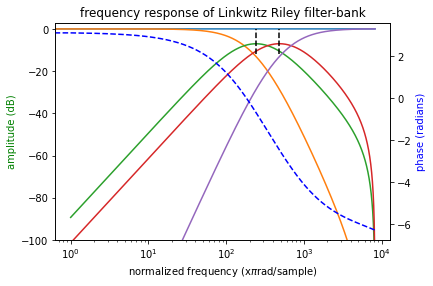

In [7]:
fc1 = 500
fc2 = 1000
fc3 = 2000

F1, F1_ = LinkwitzRiley12dB(fc1, fs)
F2, F2_ = LinkwitzRiley12dB(fc2, fs)
F3, F3_ = LinkwitzRiley12dB(fc3, fs)
A1 = [F1[0] + F1_[0], F1_[1]]
A3 = [F3[0] + F3_[0], F3_[1]]

w, apf11 = signal.freqz(A1[0], A1[1], length)
w, apf31 = signal.freqz(A3[0], A3[1], length)

w, f1  = signal.freqz(F1[0],  F1[1],  length)
w, f1_ = signal.freqz(F1_[0], F1_[1], length)
w, f2  = signal.freqz(F2[0],  F2[1],  length)
w, f2_ = signal.freqz(F2_[0], F2_[1], length)
w, f3  = signal.freqz(F3[0],  F3[1],  length)
w, f3_ = signal.freqz(F3_[0], F3_[1], length)

amplitude  = 20 * np.log10(abs(
    f2  * f1  * apf31 + 
    f2  * f1_ * apf31 + 
    f3  * f2_ * apf11 + 
    f3_ * f2_ * apf11))

amplitude1 = 20 * np.log10(abs(f2  * f1  * apf31))
amplitude2 = 20 * np.log10(abs(f2  * f1_ * apf31))
amplitude3 = 20 * np.log10(abs(f3  * f2_ * apf11))
amplitude4 = 20 * np.log10(abs(f3_ * f2_ * apf11))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(amplitude)
ax1.plot(amplitude1)
ax1.plot(amplitude2)
ax1.plot(amplitude3)
ax1.plot(amplitude4)

ax1.vlines(fc2tick(np.sqrt(fc1 * fc2), fs, length),  -12, 0, color='k', linestyle='--')
ax1.vlines(fc2tick(np.sqrt(fc2 * fc3), fs, length),  -12, 0, color='k', linestyle='--')

ax1.set_ylim(-100, 3)

ax2.plot(np.unwrap(np.angle(f2*f1*apf31 + f2*f1_*apf31 + f3*f2_*apf11 + f3_*f2_*apf11)), 'b--')

plt.title('frequency response of Linkwitz Riley filter-bank')
ax1.set_xlabel(r'normalized frequency (x$\pi$rad/sample)')
ax1.set_ylabel('amplitude (dB)', color='g')
ax2.set_ylabel('phase (radians)', color='b')
plt.xscale('log')
plt.show()

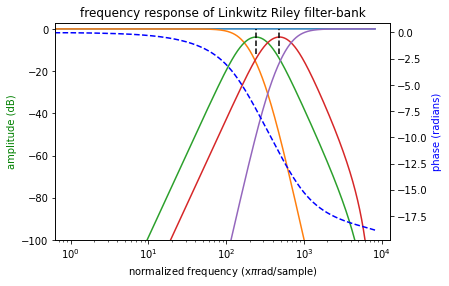

In [8]:
fc1 = 500
fc2 = 1000
fc3 = 2000

F1, F1_ = LinkwitzRiley24dB(fc1, fs)
F2, F2_ = LinkwitzRiley24dB(fc2, fs)
F3, F3_ = LinkwitzRiley24dB(fc3, fs)
A1 = [F1[0] + F1_[0], F1_[1]]
A3 = [F3[0] + F3_[0], F3_[1]]

w, apf11 = signal.freqz(A1[0], A1[1], length)
w, apf31 = signal.freqz(A3[0], A3[1], length)

w, f1  = signal.freqz(F1[0],  F1[1],  length)
w, f1_ = signal.freqz(F1_[0], F1_[1], length)
w, f2  = signal.freqz(F2[0],  F2[1],  length)
w, f2_ = signal.freqz(F2_[0], F2_[1], length)
w, f3  = signal.freqz(F3[0],  F3[1],  length)
w, f3_ = signal.freqz(F3_[0], F3_[1], length)

amplitude  = 20 * np.log10(abs(
    f2  * f1  * apf31 + 
    f2  * f1_ * apf31 + 
    f3  * f2_ * apf11 + 
    f3_ * f2_ * apf11))

amplitude1 = 20 * np.log10(abs(f2  * f1  * apf31))
amplitude2 = 20 * np.log10(abs(f2  * f1_ * apf31))
amplitude3 = 20 * np.log10(abs(f3  * f2_ * apf11))
amplitude4 = 20 * np.log10(abs(f3_ * f2_ * apf11))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(amplitude)
ax1.plot(amplitude1)
ax1.plot(amplitude2)
ax1.plot(amplitude3)
ax1.plot(amplitude4)

ax1.vlines(fc2tick(np.sqrt(fc1 * fc2), fs, length),  -12, 0, color='k', linestyle='--')
ax1.vlines(fc2tick(np.sqrt(fc2 * fc3), fs, length),  -12, 0, color='k', linestyle='--')

ax1.set_ylim(-100, 3)

ax2.plot(np.unwrap(np.angle(f2*f1*apf31 + f2*f1_*apf31 + f3*f2_*apf11 + f3_*f2_*apf11)), 'b--')

plt.title('frequency response of Linkwitz Riley filter-bank')
ax1.set_xlabel(r'normalized frequency (x$\pi$rad/sample)')
ax1.set_ylabel('amplitude (dB)', color='g')
ax2.set_ylabel('phase (radians)', color='b')
plt.xscale('log')
plt.show()

Same result as above, but cascading complementary filter and allpass filter into 4 trasnfer function as 4 individual filter output respectively.

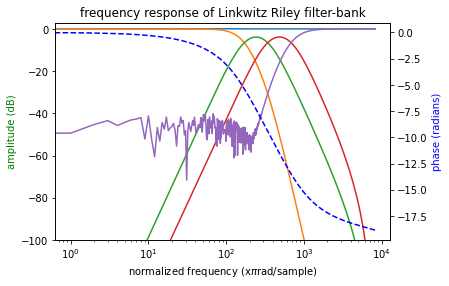

In [9]:
y1 = cascade([F2,  F1,  A3])
y2 = cascade([F2,  F1_, A3])
y3 = cascade([F3,  F2_, A1])
y4 = cascade([F3_, F2_, A1])

w, Y1 = signal.freqz(y1[0], y1[1], length)
w, Y2 = signal.freqz(y2[0], y2[1], length)
w, Y3 = signal.freqz(y3[0], y3[1], length)
w, Y4 = signal.freqz(y4[0], y4[1], length)

amplitude  = 20 * np.log10(np.abs(Y1+Y2+Y3+Y4))
amplitude1 = 20 * np.log10(np.abs(Y1))
amplitude2 = 20 * np.log10(np.abs(Y2))
amplitude3 = 20 * np.log10(np.abs(Y3))
amplitude4 = 20 * np.log10(np.abs(Y4))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(amplitude)
ax1.plot(amplitude1)
ax1.plot(amplitude2)
ax1.plot(amplitude3)
ax1.plot(amplitude4)

ax1.set_ylim(-100, 3)

ax2.plot(np.unwrap(np.angle(Y1+Y2+Y3+Y4)), 'b--')

plt.title('frequency response of Linkwitz Riley filter-bank')
ax1.set_xlabel(r'normalized frequency (x$\pi$rad/sample)')
ax1.set_ylabel('amplitude (dB)', color='g')
ax2.set_ylabel('phase (radians)', color='b')
plt.xscale('log')
plt.show()

6-band filterbank implementation using 48dB Linkwitz-Riley filter.

- 1st band cutoff:
- 2nd band cutoff:
- 3rd band cutoff:
- 4th band cutoff:
- 5th band cutoff:
- 6th band cutoff:

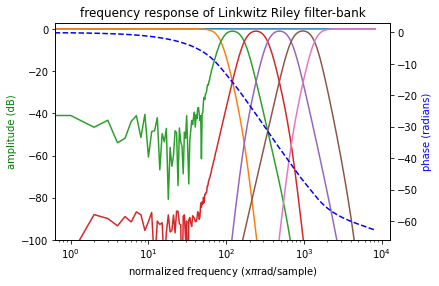

In [10]:
fc1 = 250
fc2 = 500
fc3 = 1000
fc4 = 2000
fc5 = 4000

F1, F1_ = LinkwitzRiley48dB(fc1, fs)
F2, F2_ = LinkwitzRiley48dB(fc2, fs)
F3, F3_ = LinkwitzRiley48dB(fc3, fs)
F4, F4_ = LinkwitzRiley48dB(fc4, fs)
F5, F5_ = LinkwitzRiley48dB(fc5, fs)

A1 = [F1[0] + F1_[0], F1_[1]]
A2 = [F2[0] + F2_[0], F2_[1]]
A3 = [F3[0] + F3_[0], F3_[1]]
A5 = [F5[0] + F5_[0], F5_[1]]

w, apf11 = signal.freqz(A1[0], A1[1], length)
w, apf21 = signal.freqz(A2[0], A2[1], length)
w, apf31 = signal.freqz(A3[0], A3[1], length)
w, apf51 = signal.freqz(A5[0], A5[1], length)

w, f1  = signal.freqz(F1[0],  F1[1],  length)
w, f1_ = signal.freqz(F1_[0], F1_[1], length)
w, f2  = signal.freqz(F2[0],  F2[1],  length)
w, f2_ = signal.freqz(F2_[0], F2_[1], length)
w, f3  = signal.freqz(F3[0],  F3[1],  length)
w, f3_ = signal.freqz(F3_[0], F3_[1], length)
w, f4  = signal.freqz(F4[0],  F4[1],  length)
w, f4_ = signal.freqz(F4_[0], F4_[1], length)
w, f5  = signal.freqz(F5[0],  F5[1],  length)
w, f5_ = signal.freqz(F5_[0], F5_[1], length)

amplitude  = 20 * np.log10(abs(
    f4 * apf51 * f2    * apf31 * f1  +
    f4 * apf51 * f2    * apf31 * f1_ +
    f4 * apf51 * f2_   * apf11 * f3  +
    f4 * apf51 * f2_   * apf11 * f3_ +
    f4_* apf21 * apf31 * apf11 * f5  +
    f4_* apf21 * apf31 * apf11 * f5_))

amplitude0 = 20 * np.log10(abs(f4 * apf51 * f2    * apf31 * f1 ))
amplitude1 = 20 * np.log10(abs(f4 * apf51 * f2    * apf31 * f1_))
amplitude2 = 20 * np.log10(abs(f4 * apf51 * f2_   * apf11 * f3 ))
amplitude3 = 20 * np.log10(abs(f4 * apf51 * f2_   * apf11 * f3_))
amplitude4 = 20 * np.log10(abs(f4_* apf21 * apf31 * apf11 * f5 ))
amplitude5 = 20 * np.log10(abs(f4_* apf21 * apf31 * apf11 * f5_))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(amplitude)
ax1.plot(amplitude0)
ax1.plot(amplitude1)
ax1.plot(amplitude2)
ax1.plot(amplitude3)
ax1.plot(amplitude4)
ax1.plot(amplitude5)

ax1.set_ylim(-100, 3)

ax2.plot(np.unwrap(np.angle(
    f4 * apf51 * f2    * apf31 * f1  +
    f4 * apf51 * f2    * apf31 * f1_ +
    f4 * apf51 * f2_   * apf11 * f3  +
    f4 * apf51 * f2_   * apf11 * f3_ +
    f4_* apf21 * apf31 * apf11 * f5  +
    f4_* apf21 * apf31 * apf11 * f5_)), 'b--')

plt.title('frequency response of Linkwitz Riley filter-bank')
ax1.set_xlabel(r'normalized frequency (x$\pi$rad/sample)')
ax1.set_ylabel('amplitude (dB)', color='g')
ax2.set_ylabel('phase (radians)', color='b')
plt.xscale('log')
plt.show()

7-band filterbank implementation using 48dB Linkwitz-Riley filter.

- 1st band cutoff:
- 2nd band cutoff:
- 3rd band cutoff:
- 4th band cutoff:
- 5th band cutoff:
- 6th band cutoff:
- 7th band cutoff:

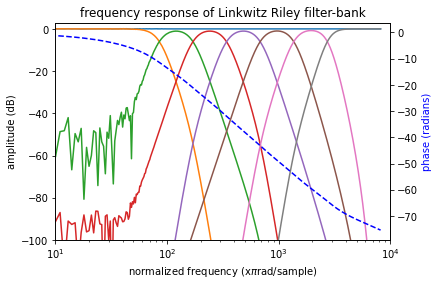

In [11]:
fc1 = 250
fc2 = 500
fc3 = 1000
fc4 = 2000
fc5 = 4000
fc6 = 8000

F1, F1_ = LinkwitzRiley48dB(fc1, fs)
F2, F2_ = LinkwitzRiley48dB(fc2, fs)
F3, F3_ = LinkwitzRiley48dB(fc3, fs)
F4, F4_ = LinkwitzRiley48dB(fc4, fs)
F5, F5_ = LinkwitzRiley48dB(fc5, fs)
F6, F6_ = LinkwitzRiley48dB(fc6, fs)

A1 = [F1[0] + F1_[0], F1_[1]]
A2 = [F2[0] + F2_[0], F2_[1]]
A3 = [F3[0] + F3_[0], F3_[1]]
A5 = [F5[0] + F5_[0], F5_[1]]
A6 = [F6[0] + F6_[0], F6_[1]]

w, apf11 = signal.freqz(A1[0], A1[1], length)
w, apf21 = signal.freqz(A2[0], A2[1], length)
w, apf31 = signal.freqz(A3[0], A3[1], length)
w, apf51 = signal.freqz(A5[0], A5[1], length)
w, apf61 = signal.freqz(A6[0], A6[1], length)

w, f1  = signal.freqz(F1[0],  F1[1],  length)
w, f1_ = signal.freqz(F1_[0], F1_[1], length)
w, f2  = signal.freqz(F2[0],  F2[1],  length)
w, f2_ = signal.freqz(F2_[0], F2_[1], length)
w, f3  = signal.freqz(F3[0],  F3[1],  length)
w, f3_ = signal.freqz(F3_[0], F3_[1], length)
w, f4  = signal.freqz(F4[0],  F4[1],  length)
w, f4_ = signal.freqz(F4_[0], F4_[1], length)
w, f5  = signal.freqz(F5[0],  F5[1],  length)
w, f5_ = signal.freqz(F5_[0], F5_[1], length)
w, f6  = signal.freqz(F6[0],  F6[1],  length)
w, f6_ = signal.freqz(F6_[0], F6_[1], length)

amplitude  = 20 * np.log10(abs(
    f4  * apf51 * apf61 * f2    * apf31 * f1  +
    f4  * apf51 * apf61 * f2    * apf31 * f1_ +
    f4  * apf51 * apf61 * f2_   * apf11 * f3  +
    f4  * apf51 * apf61 * f2_   * apf11 * f3_ +
    f4_ * apf21 * apf31 * apf11 * f5_ * f6    +
    f4_ * apf21 * apf31 * apf11 * f5_ * f6_   +
    f4_ * apf21 * apf31 * apf11 * f5 * apf61))

amplitude0 = 20 * np.log10(abs(f4  * apf51 * apf61 * f2    * apf31 * f1 ))
amplitude1 = 20 * np.log10(abs(f4  * apf51 * apf61 * f2    * apf31 * f1_))
amplitude2 = 20 * np.log10(abs(f4  * apf51 * apf61 * f2_   * apf11 * f3 ))
amplitude3 = 20 * np.log10(abs(f4  * apf51 * apf61 * f2_   * apf11 * f3_))
amplitude4 = 20 * np.log10(abs(f4_ * apf21 * apf31 * apf11 * f5 * apf61))
amplitude5 = 20 * np.log10(abs(f4_ * apf21 * apf31 * apf11 * f5_ * f6))
amplitude6 = 20 * np.log10(abs(f4_ * apf21 * apf31 * apf11 * f5_ * f6_))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(amplitude )
ax1.plot(amplitude0)
ax1.plot(amplitude1)
ax1.plot(amplitude2)
ax1.plot(amplitude3)
ax1.plot(amplitude4)
ax1.plot(amplitude5)
ax1.plot(amplitude6)

ax1.set_xlabel(r'normalized frequency (x$\pi$rad/sample)')
ax1.set_ylabel('amplitude (dB)', color='k')
ax1.set_xlim(10, 10000)
ax1.set_ylim(-100, 3)

ax2.plot(np.unwrap(np.angle(
    f4  * apf51 * apf61 * f2    * apf31 * f1  +
    f4  * apf51 * apf61 * f2    * apf31 * f1_ +
    f4  * apf51 * apf61 * f2_   * apf11 * f3  +
    f4  * apf51 * apf61 * f2_   * apf11 * f3_ +
    f4_ * apf21 * apf31 * apf11 * f5_   * f6  +
    f4_ * apf21 * apf31 * apf11 * f5_   * f6_ +
    f4_ * apf21 * apf31 * apf11 * f5    * apf61)), 'b--')

ax2.set_ylabel('phase (radians)', color='b')

plt.title('frequency response of Linkwitz Riley filter-bank')
plt.xscale('log')
plt.show()